In [1]:
%load_ext autoreload
%autoreload 3

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
import sklearn
import time

import gconcord as cc
import gconcorde as cce

In [31]:
import networkx as nx
import sklearn
import sklearn.metrics

def mcc(B, B_hat, diag=False):
    """
    Compute Matthew's Correlation Coefficient (MCC) between two matrices.
    If diag=False, it excludes diagonal elements before computing MCC.
    """
    
    B_vec = B.ravel()
    B_hat_vec = B_hat.ravel()
    
    if diag:
        return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

    p = len(B)
    indx = np.arange(0, p**2, p+1)
    B_vec = np.where(B_vec != 0, 1, 0)
    B_vec = np.delete(B_vec, indx)
    B_hat_vec = np.where(B_hat_vec != 0, 1, 0)
    B_hat_vec = np.delete(B_hat_vec, indx)
    
    return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

def standardize(X, bias=False):
    X_std = X.copy()
    X_std -= X_std.mean(axis=0)
    if bias:
        X_std /= X_std.std(axis=0)
    else:
        X_std /= X_std.std(axis=0, ddof=1)
    
    return X_std

def omega_to_corr(A):
    std_inv = np.diag(np.sqrt(1/np.diag(A)))
    A_corr = -1 * (std_inv @ A @ std_inv)
    np.fill_diagonal(A_corr, 1)
    
    return A_corr

In [32]:
# erdos-renyi

# number of variables
p = 500
# number of datasets
N = 1
# n = n_prop_to_p * p
n_prop_to_p = [100]
edge_prob = 0.1
random_state = 2022
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]
G = nx.generators.random_graphs.erdos_renyi_graph(n=p, p=edge_prob, seed=random_state)
Skel = nx.to_numpy_matrix(G)

# Peng's method (ensuring positive definiteness of precision matrix)
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(Skel, Omega)
Omega = np.tril(Omega) + np.tril(Omega).T
np.fill_diagonal(Omega, 1.5*np.abs(Omega).sum(1))
diag_inv = np.diag(1/np.sqrt(np.diag(Omega)))
Omega = diag_inv @ Omega @ diag_inv

# spread diagonal of precision matrix
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Omega = np.diag(d) @ Omega @ np.diag(d)
Cov = np.linalg.inv(Omega)
Omega_corr = omega_to_corr(Omega)

# generate Gaussian data
Xs = []
for this in n_prop_to_p:
    for j in range(N):
        rs = np.random.RandomState(random_state)
        X = rs.multivariate_normal(mean=np.zeros(p), cov=Cov, size=int(this*p))
        X_std = standardize(X, bias=False)
        Xs.append(X_std)
        random_state += 1
        
# choose length of grid for lambda
num_lams = 10

In [33]:
# concord-ista
cc_fro_norm_diff = []
cc_mccs = []
cc_objs = []
cc_update_hs = []
cc_iter_cs = []
cc_times = []
S = np.cov(Xs[0], rowvar=False)
S.flat[::S.shape[0] + 1] = 0
lam_max = 0.9 * np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), num_lams)
S = np.cov(Xs[0], rowvar=False)
for lam in lams:
    print(lam)
    start_time = time.time()
    Omega_hat, hist = cc.pyccista(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=False)
    cc_times.append(time.time() - start_time)
    
    cc_fro_norm_diff.append(np.linalg.norm(Omega-Omega_hat))
    cc_mccs.append(mcc(Omega, Omega_hat))
    temp_obj = []
    temp_update_h = []
    for i in range(len(hist)):
        temp_obj.append(hist[i][2])
        temp_update_h.append(hist[i][1])
    cc_objs.append(temp_obj)
    cc_update_hs.append(temp_update_h)
    cc_iter_cs.append(len(hist))

0.0030248596189421497
0.003906756427561784
0.0050457699553121665
0.0065168624955255945
0.008416851573044134
0.01087078182964515
0.014040154630528084
0.01813355700981572
0.023420389481555795
0.030248596189421485


In [34]:
# concorde-ista
cce_fro_norm_diff = []
cce_mccs = []
cce_objs = []
cce_update_hs = []
cce_iter_cs = []
cce_times = []
S = np.cov(Xs[0], rowvar=False)
S.flat[::S.shape[0] + 1] = 0
lam_max = 0.9 * np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), num_lams)
S = np.cov(Xs[0], rowvar=False)
for lam in lams:
    print(lam)
    start_time = time.time()
    Omega_hat, hist = cce.pycceista(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=False)
    cce_times.append(time.time() - start_time)
    Omega_hat_scaled = .5*(np.diag(np.diag(Omega_hat)) @ Omega_hat) + .5*(Omega_hat.T @ np.diag(np.diag(Omega_hat)))
    Omega_hat_scaled = np.where(np.abs(Omega_hat_scaled) < 1e-6, 0, Omega_hat_scaled)
    
    cce_fro_norm_diff.append(np.linalg.norm(Omega-Omega_hat_scaled))
    cce_mccs.append(mcc(Omega, Omega_hat_scaled))
    temp_obj = []
    temp_update_h = []
    for i in range(len(hist)):
        temp_obj.append(hist[i][2])
        temp_update_h.append(hist[i][1])
    cce_objs.append(temp_obj)
    cce_update_hs.append(temp_update_h)
    cce_iter_cs.append(len(hist))

0.0030248596189421497
0.003906756427561784
0.0050457699553121665
0.0065168624955255945
0.008416851573044134
0.01087078182964515
0.014040154630528084
0.01813355700981572
0.023420389481555795
0.030248596189421485


In [35]:
# concorde-L
ccel_fro_norm_diff = []
ccel_mccs = []
ccel_objs = []
ccel_update_hs = []
ccel_iter_cs = []
ccel_times = []
S = np.cov(Xs[0], rowvar=False)
S.flat[::S.shape[0] + 1] = 0
lam_max = 0.9 * np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), num_lams)
S = np.cov(Xs[0], rowvar=False)
for lam in lams:
    print(lam)
    start_time = time.time()
    Omega_hat, hist = cce.pycce_constant(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=False)
    ccel_times.append(time.time() - start_time)
    Omega_hat_scaled = .5*(np.diag(np.diag(Omega_hat)) @ Omega_hat) + .5*(Omega_hat.T @ np.diag(np.diag(Omega_hat)))
    Omega_hat_scaled = np.where(np.abs(Omega_hat_scaled) < 1e-6, 0, Omega_hat_scaled)
    
    ccel_fro_norm_diff.append(np.linalg.norm(Omega-Omega_hat_scaled))
    ccel_mccs.append(mcc(Omega, Omega_hat_scaled))
    temp_obj = []
    temp_update_h = []
    for i in range(len(hist)):
        temp_obj.append(hist[i][2])
        temp_update_h.append(hist[i][1])
    ccel_objs.append(temp_obj)
    ccel_update_hs.append(temp_update_h)
    ccel_iter_cs.append(len(hist))

0.0030248596189421497
0.003906756427561784
0.0050457699553121665
0.0065168624955255945
0.008416851573044134
0.01087078182964515
0.014040154630528084
0.01813355700981572
0.023420389481555795
0.030248596189421485


In [36]:
# # concorde-L-diag
# ccel_diag_fro_norm_diff = []
# ccel_diag_mccs = []
# ccel_diag_objs = []
# ccel_diag_update_hs = []
# ccel_diag_iter_cs = []
# ccel_diag_times = []
# S = np.cov(Xs[0], rowvar=False)
# S.flat[::S.shape[0] + 1] = 0
# lam_max = np.max(np.abs(S))
# lam_min = 0.01 * lam_max
# lams = np.logspace(np.log10(lam_min), np.log10(lam_max), num_lams)
# S = np.cov(Xs[0], rowvar=False)
# for lam in lams:
#     print(lam)
#     start_time = time.time()
#     Omega_hat, hist = cce.pycce_constant(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=True)
#     ccel_diag_times.append(time.time() - start_time)
#     Omega_hat_scaled = .5*(np.diag(np.diag(Omega_hat)) @ Omega_hat) + .5*(Omega_hat.T @ np.diag(np.diag(Omega_hat)))
    
#     ccel_diag_fro_norm_diff.append(np.linalg.norm(Omega-Omega_hat_scaled))
#     ccel_diag_mccs.append(mcc(Omega, Omega_hat_scaled))
#     temp_obj = []
#     temp_update_h = []
#     for i in range(len(hist)):
#         temp_obj.append(hist[i][2])
#         temp_update_h.append(hist[i][1])
#     ccel_diag_objs.append(temp_obj)
#     ccel_diag_update_hs.append(temp_update_h)
#     ccel_diag_iter_cs.append(len(hist))

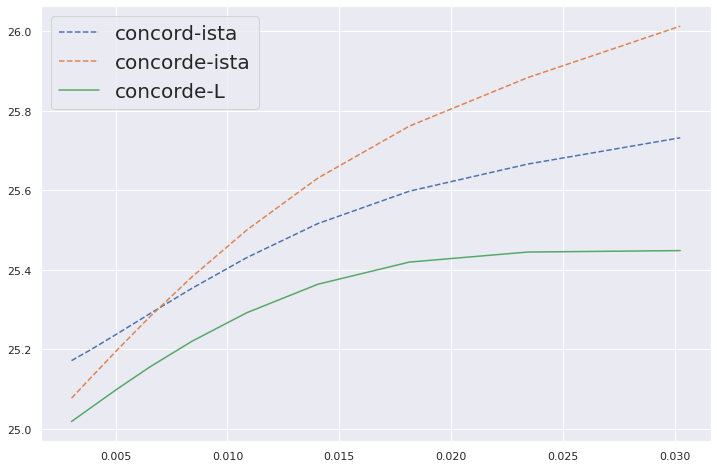

In [37]:
plt.figure(figsize=(12,8))
plt.plot(lams, cc_fro_norm_diff, label='concord-ista', linestyle='--')
plt.plot(lams, cce_fro_norm_diff, label='concorde-ista', linestyle='--')
plt.plot(lams, ccel_fro_norm_diff, label='concorde-L')
plt.legend(fontsize=20);

In [49]:
i = 5
print(cc_objs[i])
print(cce_objs[i])
print(ccel_objs[i])

[255.1466327800108, 255.0811343681942, 255.05927334934665, 255.0592559121558, 255.05925010772125, 255.05925009888443, 255.0592500959212, 255.05925009591385]
[255.1466327800108, 255.08108519198737, 255.05912991456498, 255.0590974060504, 255.05909736100512, 255.05909730412444, 255.05909730390883, 255.0590973039088]
[255.08476217158295, 255.07208567038433, 255.0731490252173, 255.0737162045397, 255.07388415205853, 255.0739293942979, 255.07394133977286, 255.0739444896459, 255.07394532334604, 255.07394554510108]


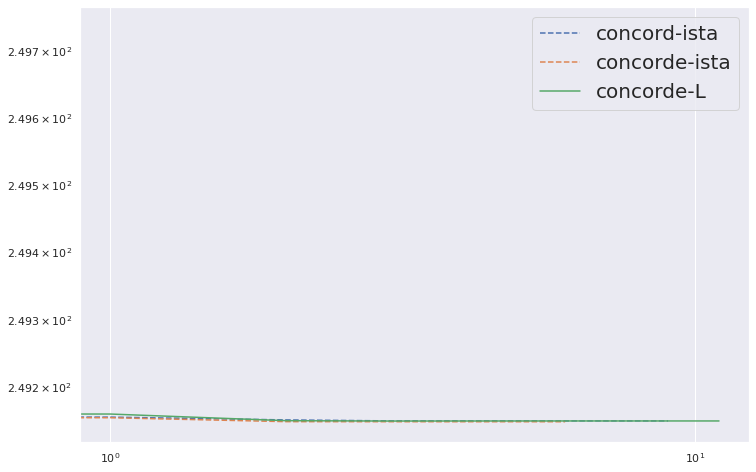

In [47]:
i = 0
plt.figure(figsize=(12,8))
plt.loglog(np.arange(cc_iter_cs[i]), cc_objs[i], label='concord-ista', linestyle='--')
plt.loglog(np.arange(cce_iter_cs[i]), cce_objs[i], label='concorde-ista', linestyle='--')
plt.loglog(np.arange(ccel_iter_cs[i]), ccel_objs[i], label='concorde-L')
plt.legend(fontsize=20);

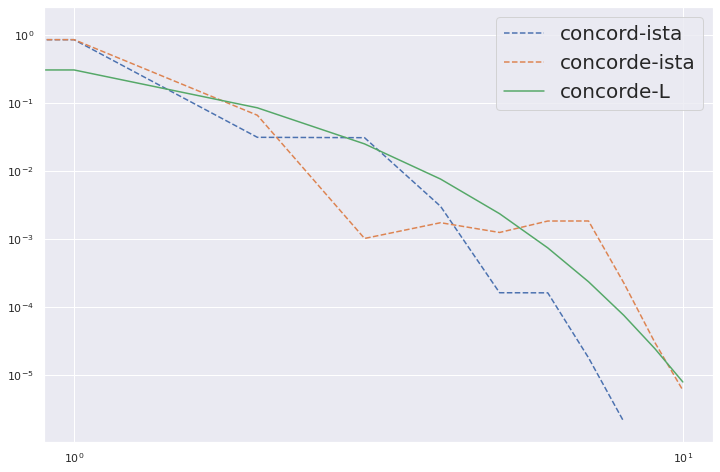

In [39]:
i = 2
plt.figure(figsize=(12,8))
plt.loglog(np.arange(len(cc_update_hs[i])), cc_update_hs[i], label='concord-ista', linestyle='--')
plt.loglog(np.arange(len(cce_update_hs[i])), cce_update_hs[i], label='concorde-ista', linestyle='--')
plt.loglog(np.arange(len(ccel_update_hs[i])), ccel_update_hs[i], label='concorde-L')
plt.legend(fontsize=20);

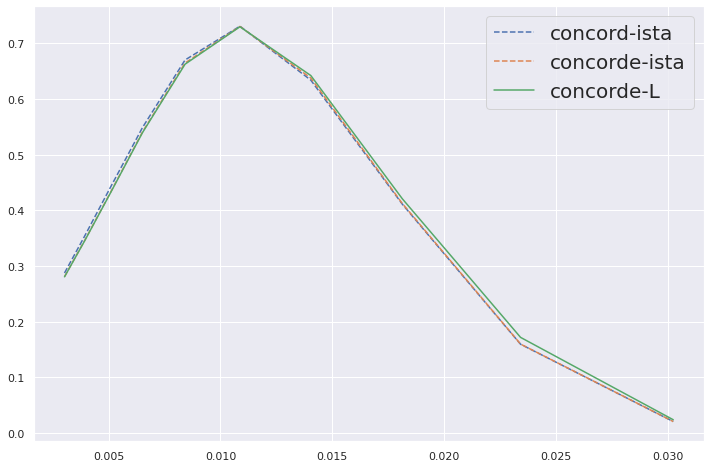

In [40]:
plt.figure(figsize=(12,8))
plt.plot(lams, cc_mccs, label='concord-ista', linestyle='--')
plt.plot(lams, cce_mccs, label='concorde-ista', linestyle='--')
plt.plot(lams, ccel_mccs, label='concorde-L')
plt.legend(fontsize=20);

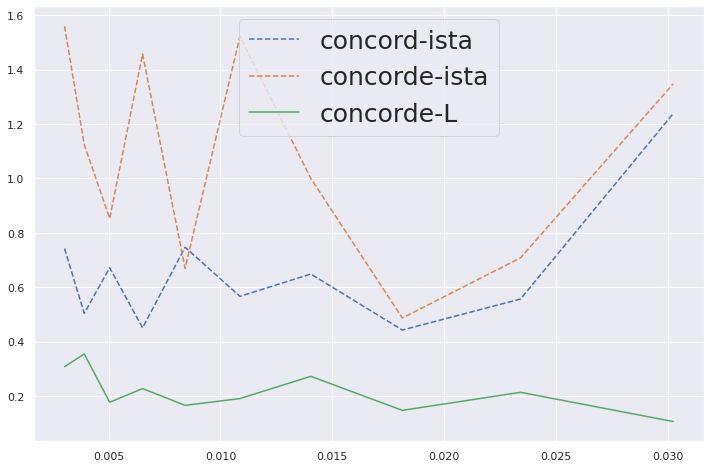

In [41]:
plt.figure(figsize=(12,8))
plt.plot(lams, cc_times, label='concord-ista', linestyle='--')
plt.plot(lams, cce_times, label='concorde-ista', linestyle='--')
plt.plot(lams, ccel_times, label='concorde-L')
plt.legend(fontsize=25);

In [160]:
S = np.cov(Xs[0], rowvar=False)
Omega_hat_ccel, hist = cce.pycce_constant(S, 0.021, epstol=1e-5, maxitr=100, penalize_diagonal=False)
Omega_hat_scaled_ccel = .5*(np.diag(np.diag(Omega_hat_ccel)) @ Omega_hat_ccel) + .5*(Omega_hat_ccel.T @ np.diag(np.diag(Omega_hat_ccel)))

In [161]:
S = np.cov(Xs[0], rowvar=False)
Omega_hat_cce, hist = cce.pycceista(S, 0.021, epstol=1e-5, maxitr=100, penalize_diagonal=False)
Omega_hat_scaled_cce = .5*(np.diag(np.diag(Omega_hat_cce)) @ Omega_hat_cce) + .5*(Omega_hat_cce.T @ np.diag(np.diag(Omega_hat_cce)))

In [ ]:
np.linalg.norm(Omega - Omega_hat_scaled_ccel)

25.114077929881013

In [162]:
np.linalg.norm(Omega - Omega_hat_scaled_cce)

25.113780260334185